In [1]:
# HyperNEO - Inferring community structure in attributed hypergraphs using stochastic block models
# Reference: 
# Kazuki Nakajima and Takeaki Uno. Inferring community structure in attributed hypergraphs using stochastic block models. 2024. arXiv.

In [2]:
# Import libraries and load the settings of our experiments.
# The object named 'settings' stores the order of node labels, the set of node label names, 
# the order of inferred communities, the hyperparameter set for each empirical hypergraph, and the random seed.

import hypergraph, hyperneo, comm_vis
settings = comm_vis.read_settings()

In [3]:
# Load a data set. 
# Specify "workplace", "hospital", "high-school", or "primary-school" as data_name. 
# In this example, specify the workplace data set.

data_name = "workplace"
#data_name = "hospital"
#data_name = "contact-high-school"
#data_name = "contact-primary-school"

G = hypergraph.read_empirical_hypergraph_data(data_name, print_info=True)

Number of nodes: 92
Number of hyperedges: 788
Average degree of the node: 17.652173913043477
Average size of the hyperedge: 2.0609137055837565
Maximum size of the hyperedge: 4
Number of different node lables: 5



In [4]:
# Set the random seed.

random_state = settings["random_state"]

print(random_state)

42


In [5]:
# Set the hyperparameters of HyperNEO.
# K : Number of overlapping communities underlying the hypergraph
# gamma : 0 <= gamma < 1. 
#         Adjusts the degree to which node attribute data is incorporated into the learning of the community structure. 
#         The higher the gamma value, the more node attribute data is incorporated into the learning.

(K, gamma) = settings[data_name]["hyperparam"]

print("K =", K, ", gamma =", gamma)

K = 5 , gamma = 0.9


In [6]:
# Fit the latent parameters (U, W, Beta) of HyperNEO to the data.

model = hyperneo.HyperNEO(G, K, gamma, random_state=random_state)
best_loglik, (U, W, Beta) = model.fit()

In [7]:
# Fix the set of node label names

label_name = settings[data_name]["label_name"]

print(label_name)

['DISQ', 'DMCT', 'DSE', 'SFLE', 'SRH']


In [8]:
# Fix the order of the indices of the node labels

label_order = settings[data_name]["label_order"]

print(label_order)

[0, 1, 2, 3, 4]


In [9]:
# Fix the order of the indices of the K inferred communities

community_order = settings[data_name]["community_order"]

print(community_order)

[0, 4, 1, 2, 3]


In [10]:
# Final value of the log-likelihood

best_loglik

1186.8274248381172

In [11]:
# Inferred membership matrix
# U is an N x K matrix. 
# The (i, k)-th element, u_ik, is the propensity that node v_i belongs to the k-th community.

U.shape, U

((92, 5),
 array([[2.42826103e+00, 7.52671200e-25, 2.48959193e-11, 2.12878775e-12,
         4.43568297e-15],
        [1.84022052e+00, 4.92011576e-03, 2.28640050e-01, 1.86312541e-03,
         4.09222316e+00],
        [1.65422241e+01, 8.12943840e-03, 4.30538969e-04, 6.08673381e-11,
         4.59046378e-05],
        [2.34527853e+00, 1.04595880e-28, 1.85357407e-10, 8.28810917e-13,
         3.26584462e-17],
        [9.19282562e-01, 1.02366453e-30, 3.07226722e-19, 3.67059482e-20,
         3.50706906e-02],
        [7.16927842e+00, 3.97094466e-10, 1.15181449e-08, 4.32547585e-11,
         3.31568890e-03],
        [1.64747888e+01, 7.39826154e-10, 6.93151475e-06, 3.73053836e-02,
         1.53443986e-02],
        [1.56415507e+01, 5.24996456e-01, 5.00325481e-07, 2.31795769e-04,
         3.96620783e-11],
        [4.30956043e+00, 3.02916791e-02, 1.11483972e-02, 7.53957195e-02,
         5.37279845e-01],
        [1.25321330e+01, 1.06624441e-03, 3.23436289e-05, 5.09287649e-02,
         3.25336228e-01],


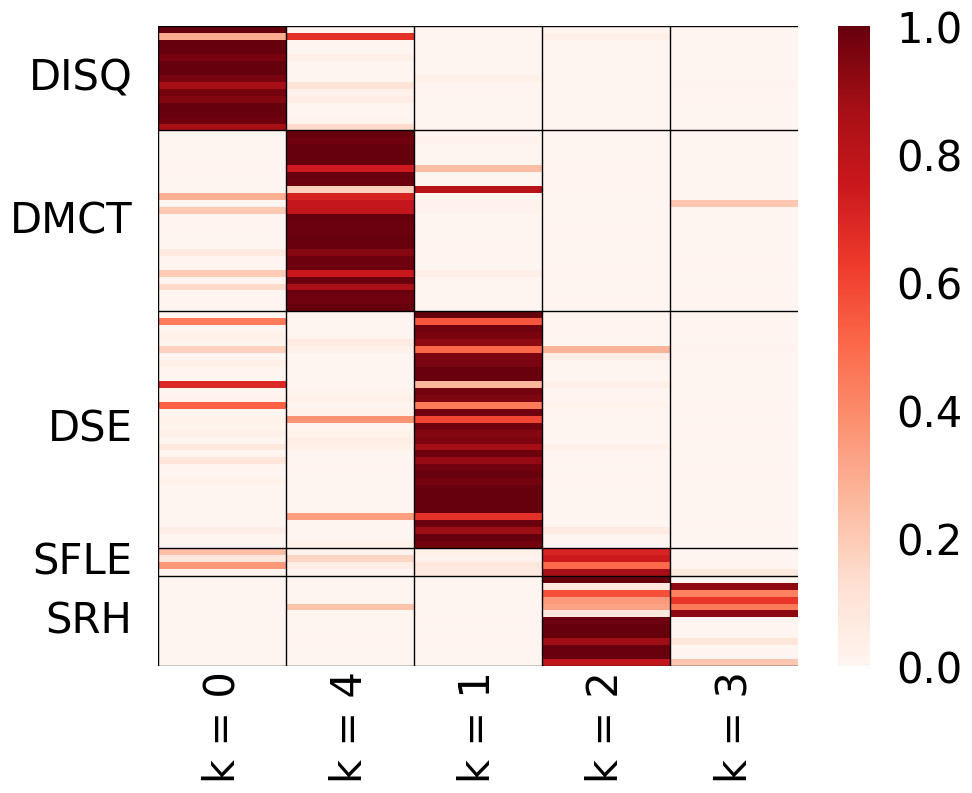

In [12]:
# Visualize a hetmap of the inferred membership matrix.
# The N row indices are arranged according to the attributes of the nodes for visualization purposes.
# Each row is normalized so that the row sum is 1 for visualization purposes.
# The figure suggests that individuals in the DISQ, DMCT, DSE, and SRH departments tend to belong to distinct communities.

comm_vis.inferred_membership_matrix(G, data_name, U, label_name, label_order, community_order)

In [13]:
# Inferred affinity matrix.
# W is a K x K matrix. 
# The matrix represents the strength of intra- and inter-community interactions among nodes.

W.shape, W

((5, 5),
 array([[1.07974399e-01, 7.07780921e-05, 1.40593271e-07, 7.68546732e-05,
         9.01768772e-06],
        [7.07780921e-05, 2.13140435e-01, 3.01226139e-08, 1.22383124e-03,
         3.59291310e-05],
        [1.40593271e-07, 3.01226139e-08, 3.87359498e-02, 3.16102534e-01,
         2.24390199e-07],
        [7.68546732e-05, 1.22383124e-03, 3.16102534e-01, 2.51215466e-06,
         2.47604804e-06],
        [9.01768772e-06, 3.59291310e-05, 2.24390199e-07, 2.47604804e-06,
         6.81205726e-02]]))

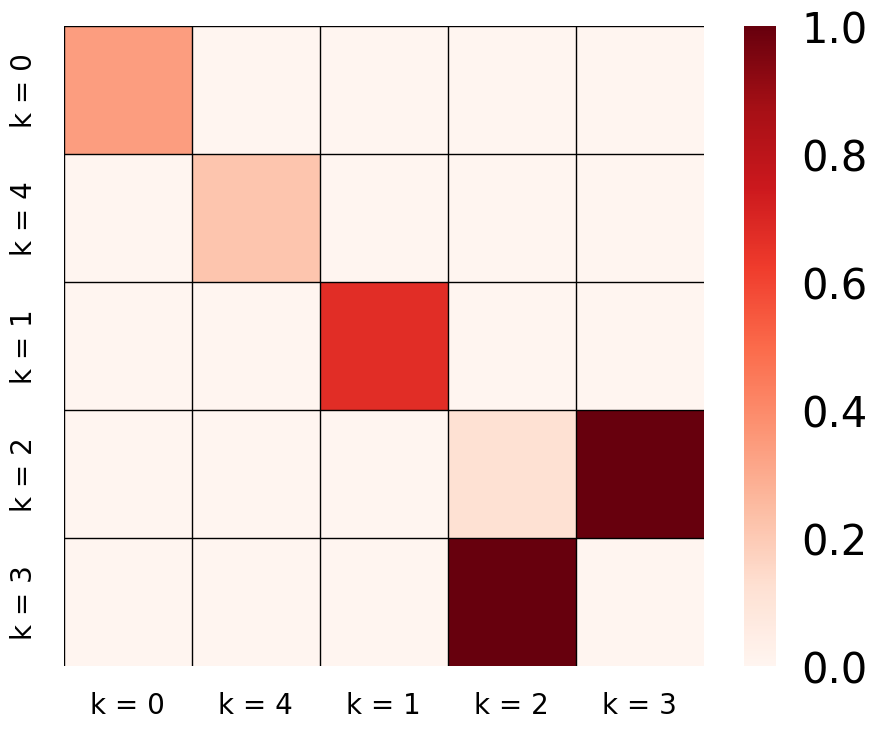

In [14]:
# Visualize a heatmap of the inferred affinity matrix.
# Each element is divided by the largest element of the matrix row so that any element is not more than 1.0 for visualization purposes.
# The figure suggests that individuals largely tend to have more intra-community contacts than inter-community contacts.

comm_vis.inferred_affinity_matrix(G, data_name, W, community_order)

/Users/kazuki/.pyenv/versions/3.9.0/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


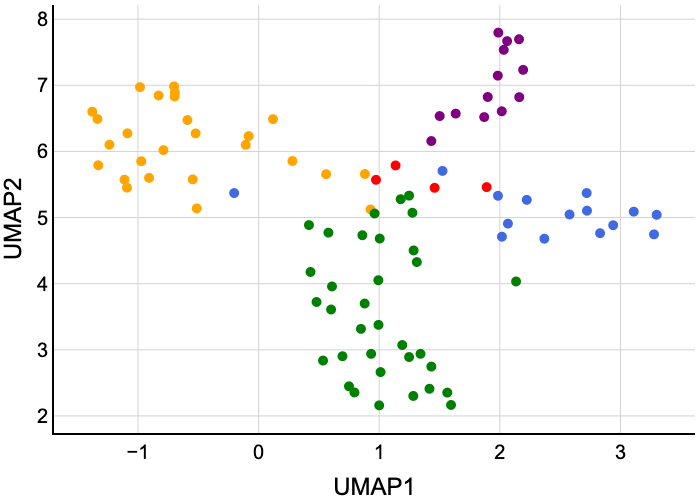

In [15]:
# Map the nodes into a two-dimensional vector space using the inferred membership and affinity matrices.
# We use the Euclidean distance in the UMAP.
# A data point represents an individual and is colored by their attribute.
# We find that individuals who have similar community memberships are positioned closely to each other.

comm_vis.node_layout(G, data_name, U, W, label_name, label_order, random_state, metric="euclidean")

/Users/kazuki/.pyenv/versions/3.9.0/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



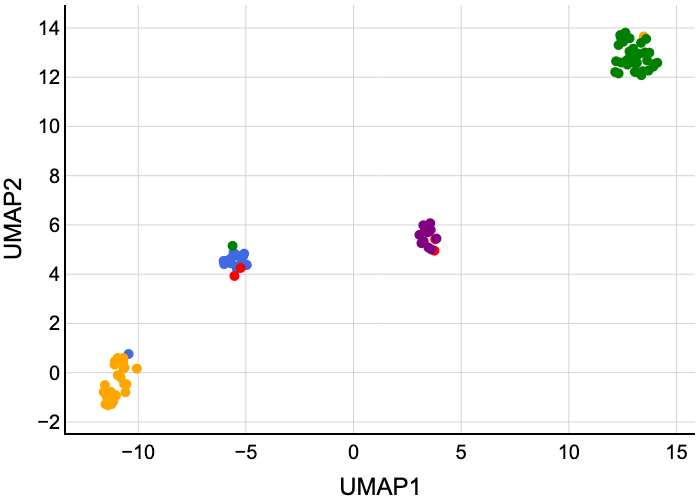

In [16]:
# Map the nodes into a two-dimensional vector space using the inferred membership and affinity matrices.
# We use the cosine distance in the UMAP.
# A data point represents an individual and is colored by their attribute.
# We are allowed an easier identification of individuals who have similar community memberships than using the cosine distance in the UMAP.

comm_vis.node_layout(G, data_name, U, W, label_name, label_order, random_state, metric="cosine")